In [2]:
from __future__ import division, print_function
import kf_book.pf_internal as pf_internal
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform
from filterpy.stats import plot_gaussian_pdf
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import operator
from collections import Counter
import pickle
import math as m

In [3]:
from numpy.random import uniform

def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

In [4]:
########################
#### Configurations ####
########################

beacons = np.array([[1, 1], [3, 4.9], [1.35, 7.7], [3.3, 10.5], [3.3, 10.5], [6, 0.5], [0.5, 3.3], [6, 10.5]])
NL = len(beacons)

pik = 'SensorModel.dat'

with open(pik, 'rb') as f:
    beacons_mean = pickle.load(f)
    beacons_stds = pickle.load(f)

In [61]:
#######################
##### Update Step #####
#######################

from operator import itemgetter 


def SensorModel(distances):
    m = itemgetter(*distances)(beacons_mean)
    s = itemgetter(*distances)(beacons_stds)
    
    return [m, s]

def update(particles, weights, z, R):
    # print(beacons)
    # print("and then")
    # print(particles[:, 0:2])
    # print("and then")
    # print(particles[:, 0:2]/10)
    # print("and then")
    # print(np.max(particles[:, 0:2]))
    # print("and then")
    # print(np.max(particles[:, 0:2]/10))
    for i, beacon in enumerate(beacons):
        distances = np.round((np.linalg.norm(particles[:, 0:2] - beacon, axis=1))/10).astype(int)
        # print(distances)
        ms, ss = SensorModel(distances)
        # print(ms)
        # print(ss)
        
        weights += np.log10(scipy.stats.norm(ms, ss).pdf(z[i]))

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize
    print("max W is : " + str(np.max(weights)))
    print("min W is : " + str(np.min(weights)))

In [62]:
#################################
##### State Estimation Step #####
#################################

def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

In [63]:
#############################
#### Particle Resampling ####
#############################

def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)
    
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]
    weights.fill(1.0 / len(weights))    

def neff(weights):
    return 1. / np.sum(np.square(weights))

In [64]:
def transition_matrix(transitions, xbins, ybins):
    # states_lookup_table = []
    # for x in range(xbins):
        # for y in range(ybins):
            # states_lookup_table.append("[" + str(x) + ", " + str(y) + "]")

    # n = 1 + len(np.array(list(set(tuple(p) for p in transitions)))) #number of unique states
    M = np.ones((xbins * ybins, xbins * ybins))
    
    for (state, state_p) in zip(transitions,transitions[1:]):
        # print("state is: ")
        # print(state)
        # print("state prime is: ")
        # print(state_p)
        # i = state[0] * (ybins - 1) + state[1]
        # j = state_p[0] * (ybins - 1) + state_p[1]
        
        i = xbins * state[1] + state[0] + 1
        j = xbins * state_p[1] + state_p[0] + 1
        
        # print(i)
        # print(j)
        # i = state[0]*xbins + state[1]
        # j = state_p[0]*xbins + state_p[1]
        # i = states_lookup_table.index(str(state))
        # j = states_lookup_table.index(str(state_p))
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

def beacon_sensor_model():
    filename = '../RSSI.csv'

In [65]:
#test:

agenttrace = '../4jul11p.csv'
f = open(agenttrace)
#print(f.readlines)
oracle_raw = []
gridized_data = []

# Information Granularity
                
gridsize = 0.5
realx = 6.6
realy = 10.6
                
xbins = int(np.ceil(realx) / gridsize)
ybins = int(np.ceil(realy) / gridsize)


# print(xbins)
# print(ybins)

with open(agenttrace, 'r') as user_data:
    reader = csv.reader(user_data, delimiter=',', quotechar=',')
    for row in reader:
        if (reader.line_num > 1):
            oracle_raw.append([float(row[4]), float(row[5])])

oracle = []
for i in range(len(oracle)):
     oracle.append([oracle_raw[i][0] * 2, oracle_raw[i][1] * 2])
            
for d in oracle:
    gridized_data.append([int(np.floor(d[0]/gridsize)), int(np.floor(d[1]/gridsize))])        


    
# print(np.max(gridized_data))

TM = transition_matrix(gridized_data, xbins, ybins)

# print(len(TM[:,1]))
# print(len(TM[1,:]))

# for row in m: 
#     print(' '.join('{0:.2f}'.format(x) for x in row))

In [66]:
with open(agenttrace, 'r') as user_data:
    reader = csv.reader(user_data, delimiter=',', quotechar=',')
    for row in reader:
        if (reader.line_num > 1):
            oracle.append([float(row[4]), float(row[5])])
            
for d in oracle:
    gridized_data.append([int(np.floor(d[0]/gridsize)), int(np.floor(d[1]/gridsize))])        

In [67]:
def CumulativeSum(m):
    return m.cumsum()

def returnobj(cdf):
    # print("aaaaaaaaaaaabbbbbbb:")
    # print(cdf)
    randnum = np.random.random()
    for i in range(len(cdf) - 1):
        if((randnum>cdf[i]) and (randnum<=cdf[i + 1])):
            return i

def IndexToState(index, xbins, ybins):
    # print("aaaaaa:")
    # print(index)
    # x = np.floor(index/(ybins + 1))
    # y = index % (ybins + 1)
    y = int(np.floor(index / xbins))
    x = index - xbins * y
    return x, y

def StateToIndex(x, y, xbins, ybins):
    i = xbins * np.floor(y) + np.floor(x)
    # print("aaaa")
    # print(x)
    # print(y)
    # print(i)
    return int(i)
    
    # return int((ybins + 1) * np.floor(x) + np.floor(y))
        
def NextStates(TM, particles, xbins, ybins):
    cdf = np.apply_along_axis(CumulativeSum, 1, TM)
    zero = np.array([0]) # np.zeros((len(cdf[:,1]))
    
    c = np.tile(zero[np.newaxis,:], (cdf.shape[0],1))
    cdf = np.concatenate((c, cdf), axis=1)
    
    # cdf = np.concatenate([np.zeros((len(cdf[:,1])), 1), cdf])
    # next_states = []
    #print(len(particles))
    next_states = np.empty((len(particles), 2))
    
    for i in range(len(particles)):
        current_state_x = particles[i, 0]
        current_state_y = particles[i, 1]
        
        row = StateToIndex(current_state_x, current_state_y, xbins, ybins)
        # print(row)
        next_state_index = returnobj(cdf[row])
        next_states[i, 0] = IndexToState(next_state_index, xbins, ybins)[0]
        next_states[i, 1] = IndexToState(next_state_index, xbins, ybins)[1]
    
    # for (state, state_p) in zip(transitions,transitions[1:]):
        # i = state[0]*xbins + state[1]
        # j = state_p[0]*xbins + state_p[1]
    
    # print(len(next_states))
    # print(next_states[:,0])
    return next_states

In [68]:
########################
##### Predict Step #####
########################

def predict(particles, xbins, ybins):
    next_states = NextStates(TM, particles, xbins, ybins)
    particles[:, 0] = next_states[:, 0]
    particles[:, 1] = next_states[:, 1]
    print("MAX location is" + str(np.max(particles)))
    return particles

In [69]:
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats

def DistanceToRSSI(agent_pos):
    rssi_values = []
    for b in beacons:
        dist = int(round(np.linalg.norm(b - agent_pos)))
        
        # Max reading is 7 meters
        if (dist > 7):
            dist = 7
        
        # print(dist)
        mean = beacons_mean[dist - 1]
        std = beacons_stds[dist - 1]
        
        sample = np.random.normal(mean, std, 1)
        rssi_values.append(sample[0])
        
    return rssi_values

def run_pf1(N, iters=18, sensor_std_err=.1, do_plot=True, plot_particles=False, xlim=(0, xbins), ylim=(0, ybins), initial_x=None):
    plt.figure()

    # create particles and weights
    particles = create_uniform_particles((0,xbins), (0,ybins), (0, 1.28), N)    
    weights = np.ones(N) / N
    
    xs = []
    # robot_pos = np.array([0., 0.])
    step = 1
    for gt in range(len(oracle)):
        plt.figure()
        print(step)
        step = step + 1
        # Agent's current location
        agent_pos = oracle[gt]
        # print("aaaa")
        print(agent_pos)
        # move particles based on transition matrix
        # predict(particles, u=(0.00, 1.414), std=(.2, .05))
        particles = predict(particles, xbins, ybins)
        
        # Observation from Beacons' RSSI
        zs =  DistanceToRSSI(agent_pos)
        
        # Weighting particles based on our observation 
        update(particles, weights, z = zs, R = sensor_std_err)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

        # if plot_particles:
            # plt.scatter(particles[:, 0], particles[:, 1], color='k', marker=',', s=1)
        
        p1 = plt.scatter(agent_pos[0], agent_pos[1], marker='+', color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    
        if plot_particles:
            alpha = .2
            if N > 5000:
                alpha *= np.sqrt(5000)/np.sqrt(N)           
            plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, color='b')
        
        xs_new = np.array(xs)
        # plt.plot(xs[:, 0], xs[:, 1])
        plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
        plt.xlim(*xlim)
        plt.ylim(*ylim)
        print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
        plt.show()

1
[2.298139, 5.403299]
MAX location is21.0
max W is : 0.0002433520847786623
min W is : 0.00018034131012205327
final position error, variance:
	 [-11.62731243  -7.54839944] [15.94582747 38.24893648]


<Figure size 432x288 with 0 Axes>

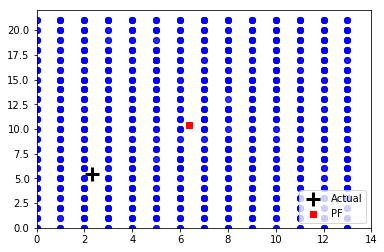

2
[2.298263, 5.403079]
MAX location is21.0
max W is : 0.00022401978548695754
min W is : 0.00018464839275734803
final position error, variance:
	 [-11.51687779  -7.83914191] [16.01716228 39.83060257]


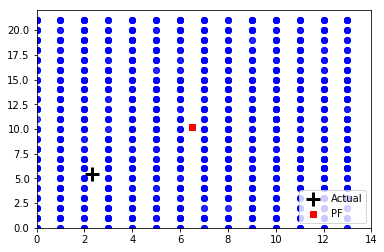

3
[2.298387, 5.402859]
MAX location is21.0
max W is : 0.0002457431416610781
min W is : 0.00018247355014817934
final position error, variance:
	 [-11.53509222  -7.37171965] [15.57913672 37.70459555]


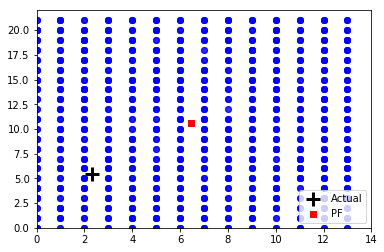

4
[2.298511, 5.402639]
MAX location is21.0
max W is : 0.00022286053285779995
min W is : 0.00018379745919073955
final position error, variance:
	 [-11.60228073  -7.83801327] [16.25879056 39.52401653]


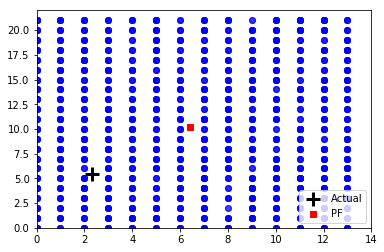

5
[2.298635, 5.402419]
MAX location is21.0
max W is : 0.00024294244591152524
min W is : 0.00018114588889003714
final position error, variance:
	 [-11.65324427  -7.30536062] [15.96903308 38.88451033]


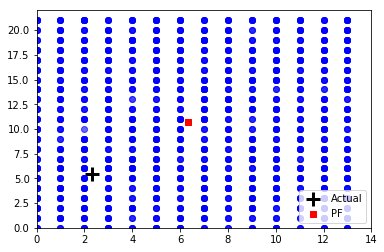

6
[2.298759, 5.402199]
MAX location is21.0
max W is : 0.00022097906461600108
min W is : 0.0001869109738056907
final position error, variance:
	 [-11.44479717  -7.71808113] [16.11448956 40.37167755]


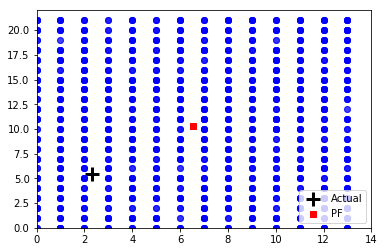

7
[2.298883, 5.401979]
MAX location is21.0
max W is : 0.00020927090361530629
min W is : 0.00019400717616805915
final position error, variance:
	 [-11.61088841  -7.54450478] [16.35935259 39.88213619]


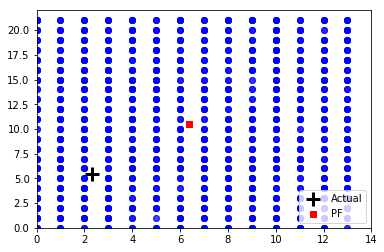

8
[2.299007, 5.40176]
MAX location is21.0
max W is : 0.0002473032133379381
min W is : 0.00016352333138590884
final position error, variance:
	 [-11.64422761  -7.98699622] [16.10241743 39.91782986]


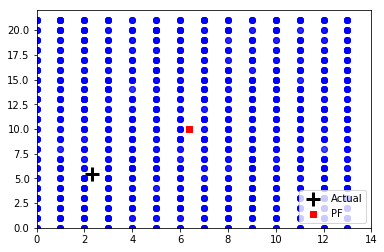

9
[2.299132, 5.40154]
MAX location is21.0
max W is : 0.00022994400275013952
min W is : 0.00018637898271869202
final position error, variance:
	 [-11.57056242  -7.72330088] [15.62819034 39.08151693]


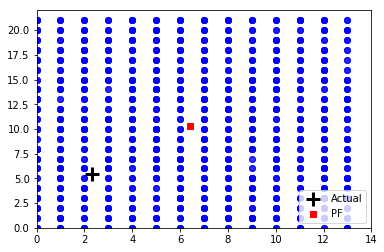

10
[2.299256, 5.40132]
MAX location is21.0
max W is : 0.00023882331360487597
min W is : 0.00018341584373815595
final position error, variance:
	 [-11.7157532   -7.58693365] [16.16697917 38.38420264]


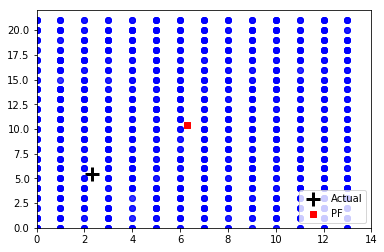

11
[2.299504, 5.40088]
MAX location is21.0
max W is : 0.00021646191737051084
min W is : 0.00018681692630253903
final position error, variance:
	 [-11.66546673  -7.68180738] [16.22031763 39.30058294]


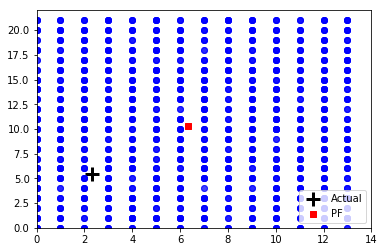

12
[2.299628, 5.40066]
MAX location is21.0
max W is : 0.0002164094346540141
min W is : 0.00018306818809663526
final position error, variance:
	 [-11.65546879  -7.94110535] [15.85506666 40.12776665]


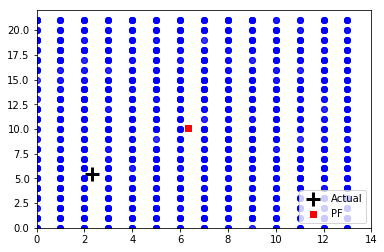

13
[2.299752, 5.40044]
MAX location is21.0
max W is : 0.00022667026848009463
min W is : 0.00018570349469660557
final position error, variance:
	 [-11.58296037  -7.66216766] [15.81158612 38.65673326]


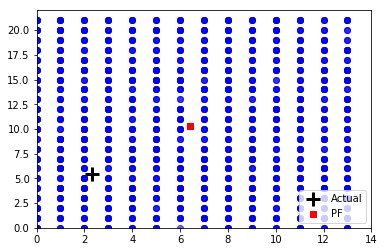

14
[2.299876, 5.40022]
MAX location is21.0
max W is : 0.00022694452300601586
min W is : 0.00018729909452291032
final position error, variance:
	 [-11.61421686  -7.58996571] [16.34722946 39.57136999]


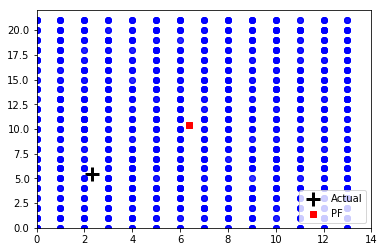

15
[2.3, 5.4]
MAX location is21.0
max W is : 0.0002316143312199294
min W is : 0.00017634307435225187
final position error, variance:
	 [-11.50448821  -7.8137021 ] [15.54227536 38.56027509]


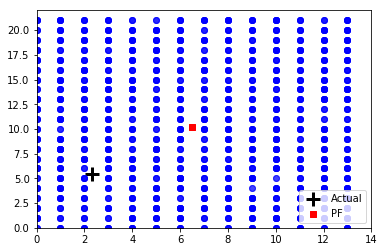

16
[2.3, 5.4]
MAX location is21.0
max W is : 0.00022932495465016221
min W is : 0.00017856953075271178
final position error, variance:
	 [-11.50820847  -7.89785715] [16.02776304 39.05337473]


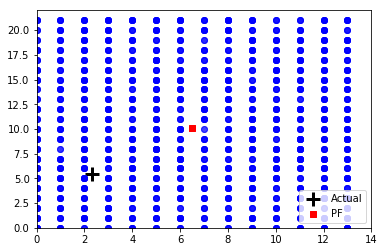

17
[2.3, 5.4]
MAX location is21.0
max W is : 0.00021077269115560868
min W is : 0.0001893204079968872
final position error, variance:
	 [-11.56465236  -7.66166405] [16.2807851  38.92689623]


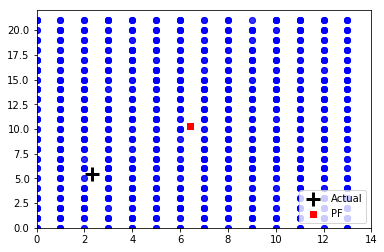

18
[2.3, 5.4]
MAX location is21.0
max W is : 0.00021469667809891646
min W is : 0.00018771743995148695
final position error, variance:
	 [-11.43814936  -7.86200267] [15.89742009 39.68803798]


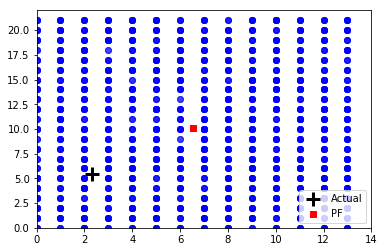

19
[2.3, 5.4]
MAX location is21.0
max W is : 0.0002099242845146849
min W is : 0.0001927781839285326
final position error, variance:
	 [-11.46928189  -7.58390456] [16.11037986 40.21141855]


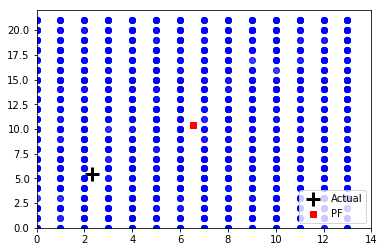

20
[2.3, 5.4]
MAX location is21.0
max W is : 0.00021891188991324525
min W is : 0.00019267219991092946
final position error, variance:
	 [-11.59513485  -7.75689221] [16.45780758 40.15969116]


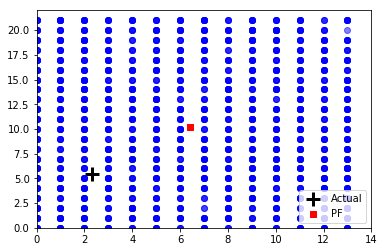

21
[2.3, 5.4]
MAX location is21.0
max W is : 0.00024806740670065675
min W is : 0.00016450674220819784
final position error, variance:
	 [-11.67387783  -8.11044105] [15.80378267 39.59832057]


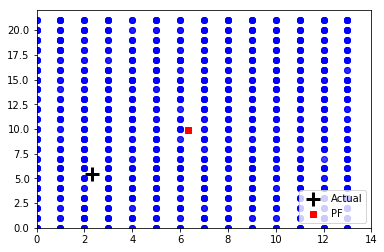

22
[2.3, 5.4]
MAX location is21.0
max W is : 0.00023007102831600532
min W is : 0.00018284514915723
final position error, variance:
	 [-11.66562918  -7.71946839] [15.91436909 38.85672255]


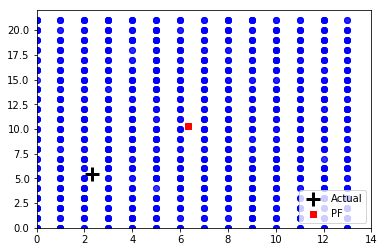

23
[2.3, 5.4]
MAX location is21.0
max W is : 0.00022640316986128944
min W is : 0.00018007501482336758
final position error, variance:
	 [-11.53517133  -7.8336904 ] [15.55193517 38.7083113 ]


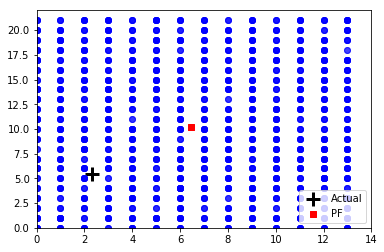

24
[2.3, 5.4]
MAX location is21.0
max W is : 0.00023599386070595666
min W is : 0.00018059190042509055
final position error, variance:
	 [-11.54613558  -7.89997746] [15.91081565 40.33505337]


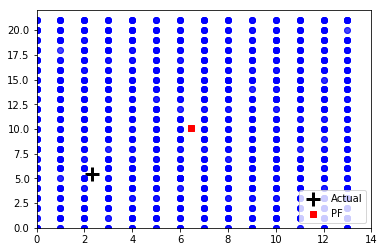

25
[2.3, 5.4]
MAX location is21.0
max W is : 0.00021298321803242824
min W is : 0.00019243165525707157
final position error, variance:
	 [-11.47802158  -7.51163144] [16.37313073 39.25052106]


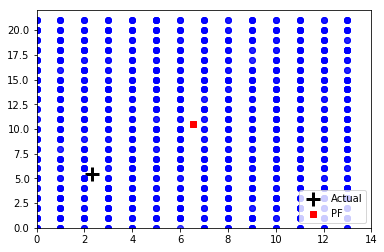

26
[2.3, 5.4]
MAX location is21.0
max W is : 0.00022738062708734693
min W is : 0.0001884181371973637
final position error, variance:
	 [-11.59386965  -7.76104498] [16.36529275 40.73505302]


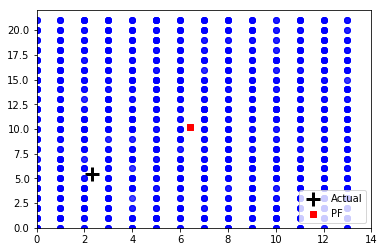

27
[2.3, 5.4]
MAX location is21.0
max W is : 0.00023122428324905304
min W is : 0.00017650240547767405
final position error, variance:
	 [-11.56497422  -7.85798148] [15.58708563 38.2492622 ]


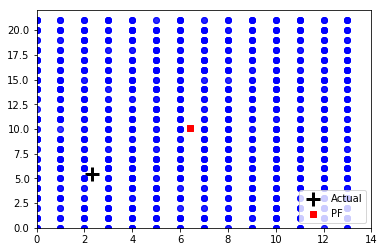

28
[2.3, 5.4]
MAX location is21.0
max W is : 0.00023296919320896844
min W is : 0.0001870233124091381
final position error, variance:
	 [-11.65893877  -7.63915869] [16.25366662 38.70649378]


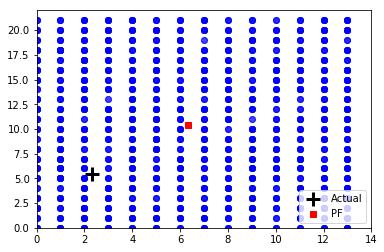

29
[2.3, 5.4]
MAX location is21.0
max W is : 0.00024025026215456228
min W is : 0.00017409054238129264
final position error, variance:
	 [-11.56521398  -8.05946675] [15.89987363 40.9505654 ]


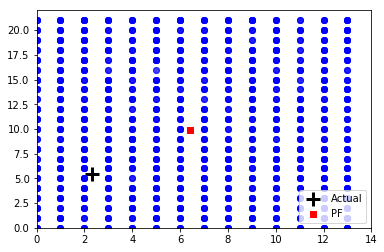

30
[2.3, 5.4]
MAX location is21.0
max W is : 0.00022159128818000255
min W is : 0.0001885376277058333
final position error, variance:
	 [-11.59148586  -7.46724749] [15.78741625 39.24566288]


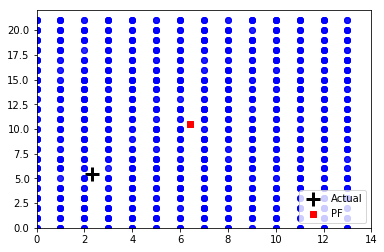

31
[2.3, 5.4]
MAX location is21.0
max W is : 0.00021334225009981452
min W is : 0.00019387793386139586
final position error, variance:
	 [-11.58174311  -7.55785751] [15.90266179 40.21017692]


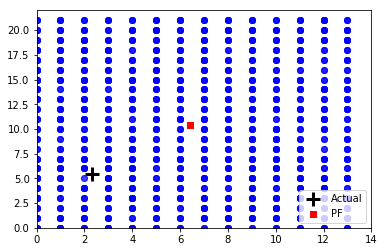

32
[2.3, 5.4]
MAX location is21.0
max W is : 0.0002144200314823214
min W is : 0.00019061502854534772
final position error, variance:
	 [-11.56548775  -7.56115074] [16.41862738 39.83985431]


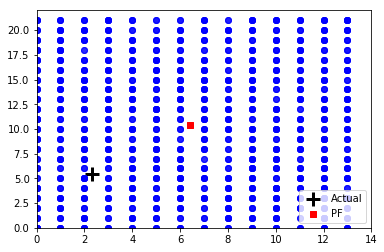

33
[2.677778, 5.788889]
MAX location is21.0
max W is : 0.00022995437346492778
min W is : 0.0001863338103720606
final position error, variance:
	 [-11.57591483  -7.62153386] [15.8447247  39.42232809]


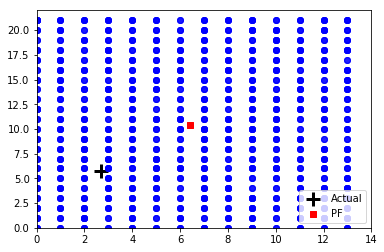

34
[3.055556, 6.177778]
MAX location is21.0
max W is : 0.00026113516584838457
min W is : 0.00016766060328756883
final position error, variance:
	 [-11.6834915   -8.09334527] [16.23960891 39.59081733]


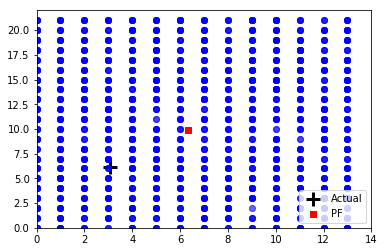

35
[3.433333, 6.566667]
MAX location is21.0
max W is : 0.0002417931309924063
min W is : 0.00016912305619551897
final position error, variance:
	 [-11.71691478  -7.93348623] [15.50093209 39.27408054]


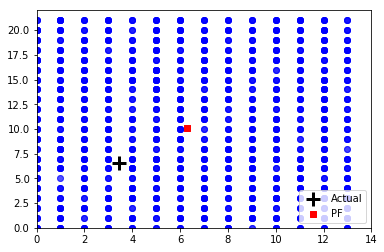

36
[3.811111, 6.955556]
MAX location is21.0
max W is : 0.00023583798783820614
min W is : 0.00017673378335421092
final position error, variance:
	 [-11.52013559  -7.93945659] [16.22042821 40.40954987]


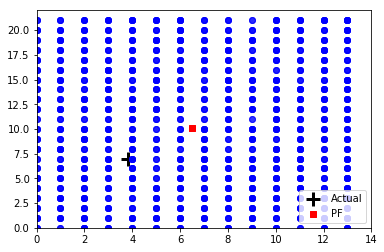

37
[4.188889, 7.344444]
MAX location is21.0
max W is : 0.0002699417672350824
min W is : 0.00016082519193562686
final position error, variance:
	 [-11.70871532  -8.37622458] [15.97965506 39.8822706 ]


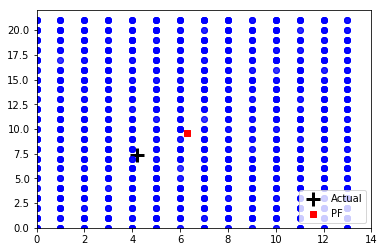

38
[4.566667, 7.733333]
MAX location is21.0
max W is : 0.0002629168030658132
min W is : 0.00016787181451650377
final position error, variance:
	 [-11.63440151  -8.33744397] [16.09814872 40.9049279 ]


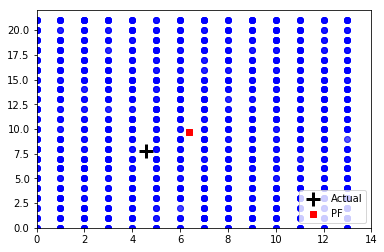

39
[4.944444, 8.122222]
MAX location is21.0
max W is : 0.00020331316886140391
min W is : 0.0001939909202297066
final position error, variance:
	 [-11.42833653  -7.3077462 ] [15.9697587  41.76981018]


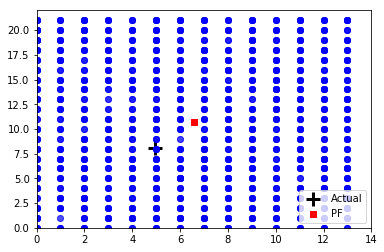

40
[5.322222, 8.511111]
MAX location is21.0
max W is : 0.0002529469161383758
min W is : 0.0001693505165186269
final position error, variance:
	 [-11.67663534  -8.09088759] [16.69573328 38.9403327 ]


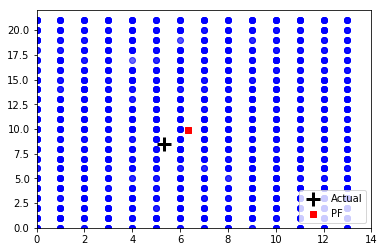

41
[5.7, 8.9]
MAX location is21.0
max W is : 0.00024265651258344504
min W is : 0.0001801781654793914
final position error, variance:
	 [-11.67151725  -7.74684646] [16.1372221  39.71980176]


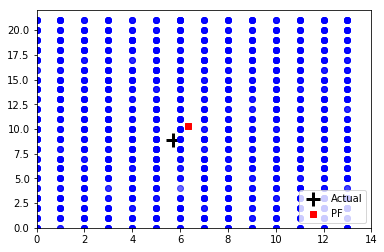

42
[5.7, 8.9]
MAX location is21.0
max W is : 0.0002597984728179446
min W is : 0.00017019970723540495
final position error, variance:
	 [-11.81205595  -8.17897951] [16.09197722 40.01303834]


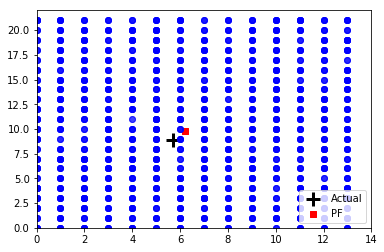

43
[5.7, 8.9]
MAX location is21.0
max W is : 0.00026850906603771506
min W is : 0.00016382467992669315
final position error, variance:
	 [-11.91016031  -8.23250387] [16.24657182 39.07244962]


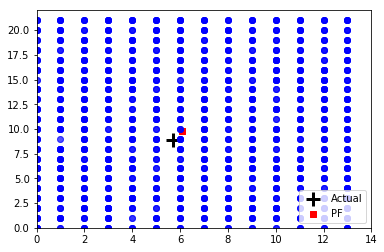

44
[5.7, 8.9]
MAX location is21.0
max W is : 0.0002461317918857173
min W is : 0.00017511204657558676
final position error, variance:
	 [-11.6721728   -7.98696275] [16.36120263 40.27479552]


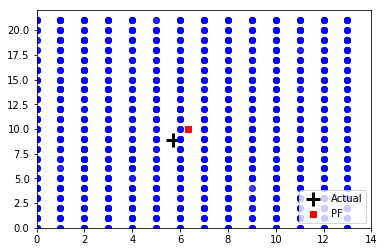

45
[5.7, 8.9]
MAX location is21.0
max W is : 0.0002555561530354404
min W is : 0.00016552767656861838
final position error, variance:
	 [-11.76810902  -8.1570631 ] [15.67819895 39.15542382]


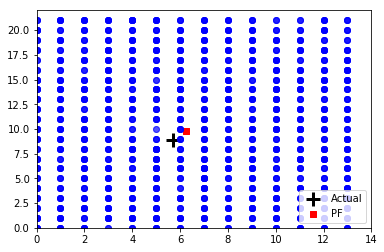

46
[5.7, 8.9]
MAX location is21.0
max W is : 0.0002199697506546732
min W is : 0.00019083862834339961
final position error, variance:
	 [-11.45956505  -7.69636856] [15.98293197 40.245747  ]


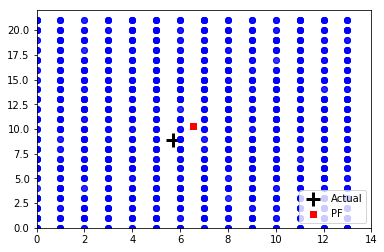

47
[5.7, 8.9]
MAX location is21.0
max W is : 0.00024850951483193815
min W is : 0.000176470325526949
final position error, variance:
	 [-11.55874631  -8.04793459] [15.59119812 40.82407236]


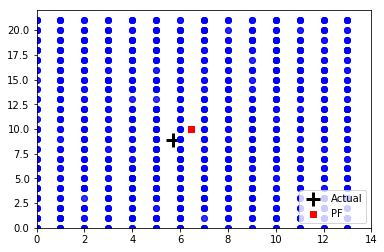

48
[5.7, 8.9]
MAX location is21.0
max W is : 0.0003000393095494035
min W is : 0.00014735470387166008
final position error, variance:
	 [-11.73412798  -8.5899963 ] [16.19034802 39.06767601]


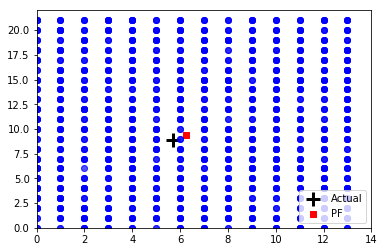

49
[5.7, 8.9]
MAX location is21.0
max W is : 0.0002184933693658274
min W is : 0.0001896349852731274
final position error, variance:
	 [-11.4482191   -7.79983036] [15.85214194 40.39542563]


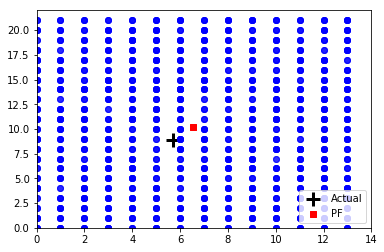

50
[5.7, 8.9]
MAX location is21.0
max W is : 0.0002619658676923024
min W is : 0.00016572941467324622
final position error, variance:
	 [-11.68640074  -8.32216824] [15.9012279  39.74383384]


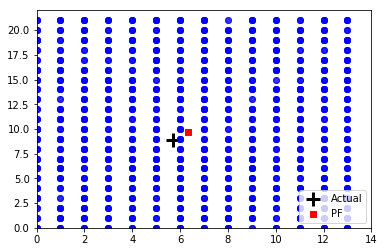

51
[5.7, 8.9]
MAX location is21.0
max W is : 0.00022764761599298528
min W is : 0.0001908773560606422
final position error, variance:
	 [-11.52866028  -7.66642484] [16.26539262 40.23993348]


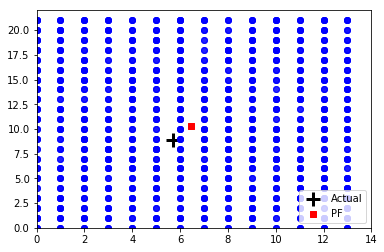

52
[5.7, 8.9]
MAX location is21.0
max W is : 0.00024928312244001477
min W is : 0.0001697896379104498
final position error, variance:
	 [-11.60470741  -8.07733545] [15.81286698 40.20589193]


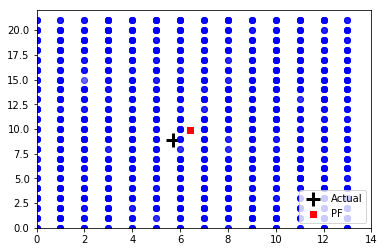

53
[4.0, 7.15]
MAX location is21.0
max W is : 0.00022288171533248164
min W is : 0.0001917364345747977
final position error, variance:
	 [-11.5622125   -7.68585463] [16.37133343 40.66732222]


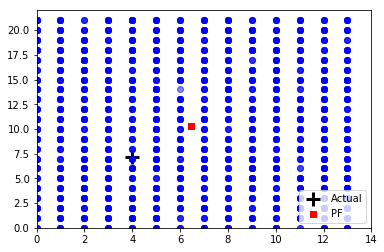

54
[2.3, 5.4]
MAX location is21.0
max W is : 0.0002111638702524528
min W is : 0.00019466099739539675
final position error, variance:
	 [-11.55469327  -7.44646943] [16.0541465  39.36634755]


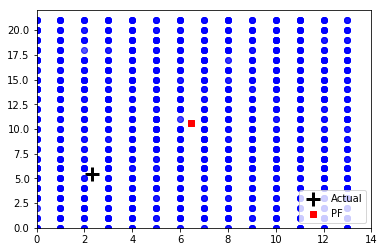

55
[2.3, 5.4]
MAX location is21.0
max W is : 0.00020740891066879107
min W is : 0.00019345470315976137
final position error, variance:
	 [-11.43064038  -7.60047965] [16.23377259 40.74161684]


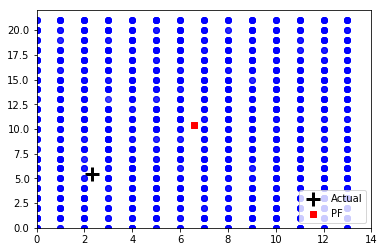

56
[2.3, 5.4]
MAX location is21.0
max W is : 0.0002294657075061112
min W is : 0.00017704908828149405
final position error, variance:
	 [-11.55336772  -7.84669173] [15.39118897 38.25632079]


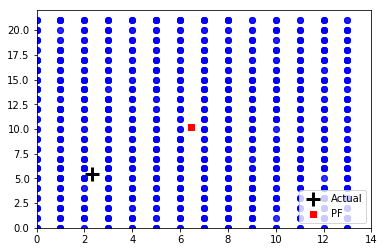

57
[2.3, 5.4]
MAX location is21.0
max W is : 0.0002243245334417131
min W is : 0.00018539588196794915
final position error, variance:
	 [-11.61681821  -7.81670038] [16.21306206 40.27175267]


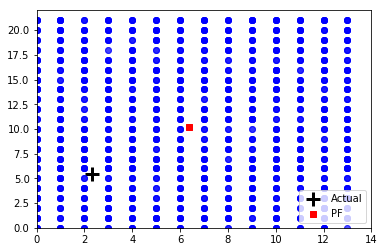

58
[2.3, 5.4]
MAX location is21.0
max W is : 0.0002144510847401312
min W is : 0.00019188685045002773
final position error, variance:
	 [-11.62198973  -7.70086767] [16.08710791 39.84703371]


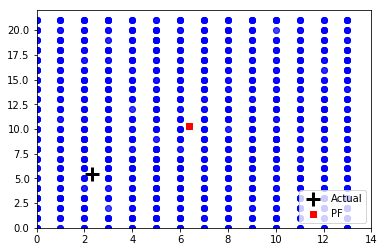

59
[2.3, 5.4]
MAX location is21.0
max W is : 0.00023868692349231533
min W is : 0.00017245170611773322
final position error, variance:
	 [-11.54289548  -7.80291948] [15.48534553 38.46544316]


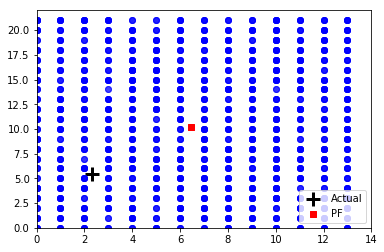

60
[2.3, 5.4]
MAX location is21.0
max W is : 0.00022008551942856523
min W is : 0.00018817362972391454
final position error, variance:
	 [-11.4976953   -7.85817055] [15.4742712  39.47848528]


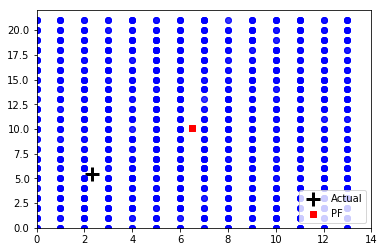

61
[4.0, 7.15]
MAX location is21.0
max W is : 0.00021591681549591992
min W is : 0.00018995659658367894
final position error, variance:
	 [-11.55740841  -7.58637223] [16.19668023 39.49752669]


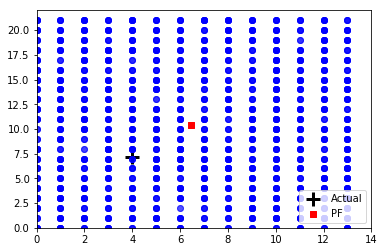

62
[5.7, 8.9]
MAX location is21.0
max W is : 0.00022592862635329618
min W is : 0.0001794296640825074
final position error, variance:
	 [-11.62643907  -7.80581837] [16.43065936 39.86333237]


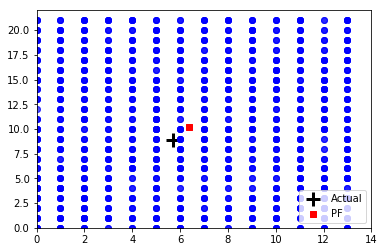

63
[5.7, 8.9]
MAX location is21.0
max W is : 0.000275461472283541
min W is : 0.00015527992431214882
final position error, variance:
	 [-11.85692     -8.23259975] [16.12838795 38.71204446]


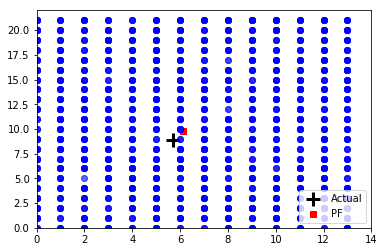

64
[5.7, 8.9]
MAX location is21.0
max W is : 0.0002903618421831532
min W is : 0.0001524183709606061
final position error, variance:
	 [-11.58308465  -8.54191176] [15.5184838 39.380319 ]


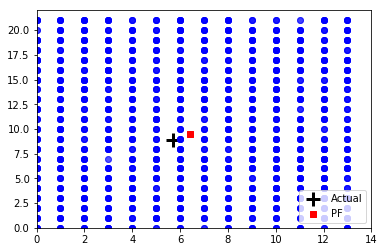

65
[5.7, 8.9]
MAX location is21.0
max W is : 0.0002069210077778628
min W is : 0.00019533042674462286
final position error, variance:
	 [-11.46508439  -7.53621545] [16.24694074 40.75541267]


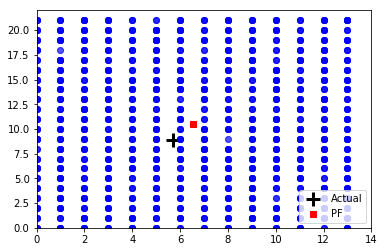

66
[5.7, 8.9]
MAX location is21.0
max W is : 0.0002628262354066539
min W is : 0.0001622485703318978
final position error, variance:
	 [-11.76071046  -8.34381785] [16.23050818 39.22210157]


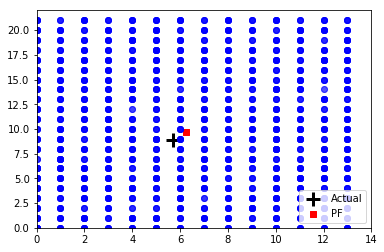

67
[5.7, 8.9]
MAX location is21.0
max W is : 0.00028007528429761086
min W is : 0.00015161748084140838
final position error, variance:
	 [-11.91817352  -8.52609182] [16.08913805 38.13095921]


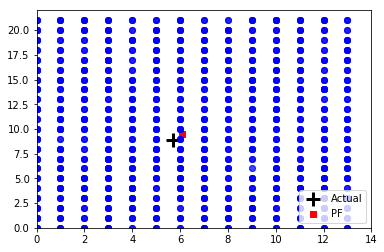

68
[5.7, 8.9]
MAX location is21.0
max W is : 0.0002526013121712642
min W is : 0.0001705821866752029
final position error, variance:
	 [-11.6704742   -8.07916211] [16.33542724 40.16856194]


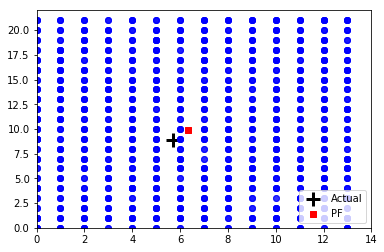

69
[5.7, 8.9]
MAX location is21.0
max W is : 0.00027500491420688925
min W is : 0.00015813395625599393
final position error, variance:
	 [-11.4732812   -8.37700135] [15.5887979  39.45640583]


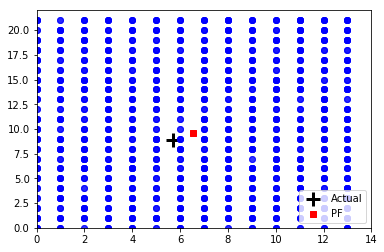

70
[5.7, 8.9]
MAX location is21.0
max W is : 0.00025486998829802855
min W is : 0.00016698208425125743
final position error, variance:
	 [-11.76636969  -8.02903379] [16.16286286 38.41533351]


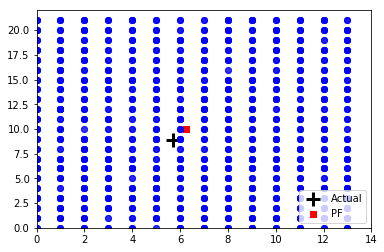

71
[5.7, 8.9]
MAX location is21.0
max W is : 0.0002605399055733391
min W is : 0.00016552368098753616
final position error, variance:
	 [-11.57372343  -8.2501463 ] [15.57711242 38.9008832 ]


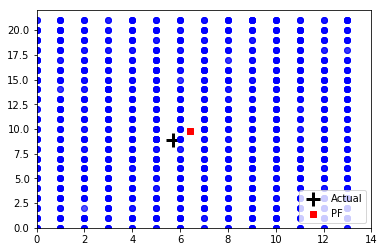

72
[5.7, 8.9]
MAX location is21.0
max W is : 0.00023333856604647516
min W is : 0.0001735755231395546
final position error, variance:
	 [-11.57866451  -7.67780843] [16.36350402 38.607871  ]


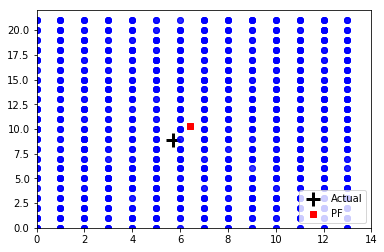

73
[5.7, 8.9]
MAX location is21.0
max W is : 0.00022705220318040785
min W is : 0.00018075982379366394
final position error, variance:
	 [-11.59621997  -7.82809019] [16.29505654 39.20712973]


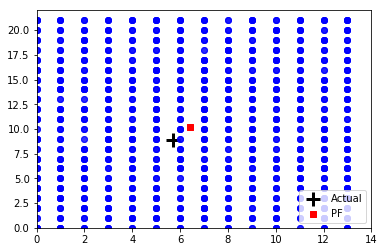

74
[5.7, 8.9]
MAX location is21.0
max W is : 0.00024583287945696355
min W is : 0.00017206814791532977
final position error, variance:
	 [-11.6120563   -7.67036419] [15.9703759  40.07180002]


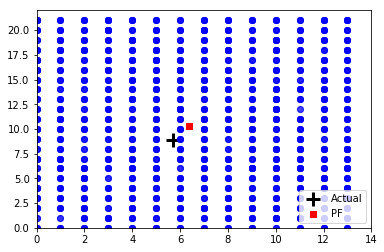

75
[5.7, 8.9]
MAX location is21.0
max W is : 0.00025739347248254405
min W is : 0.00016911952326684955
final position error, variance:
	 [-11.66107038  -8.05038902] [16.44230716 40.02870587]


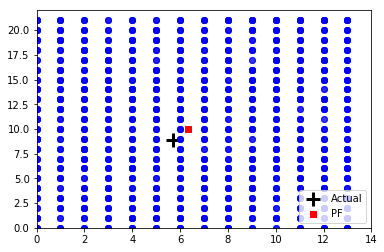

76
[5.7, 8.9]
MAX location is21.0
max W is : 0.0002498723071300596
min W is : 0.00016706324963930848
final position error, variance:
	 [-11.79240116  -8.02880982] [16.13551824 39.49962773]


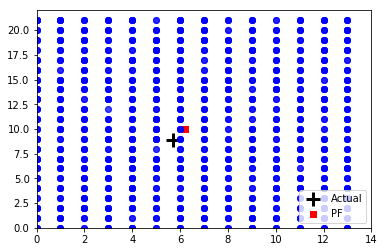

77
[5.7, 8.9]
MAX location is21.0
max W is : 0.0002473648272326985
min W is : 0.00016845642687533807
final position error, variance:
	 [-11.54710353  -7.946342  ] [16.23623027 39.077204  ]


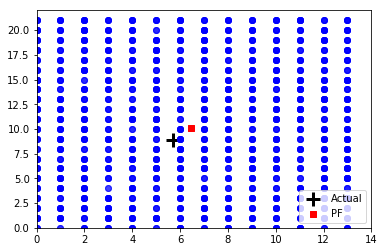

78
[5.7, 8.9]
MAX location is21.0
max W is : 0.000269008482096587
min W is : 0.00016504411210267514
final position error, variance:
	 [-11.82796885  -8.36191406] [16.42374007 38.9055753 ]


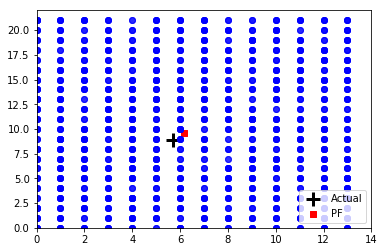

79
[5.7, 8.9]
MAX location is21.0
max W is : 0.0002949465107279268
min W is : 0.00014025427922721232
final position error, variance:
	 [-11.8233524   -8.62017626] [15.96046335 37.98282077]


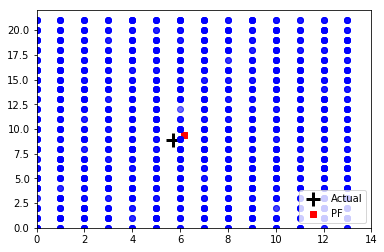

80
[5.7, 8.9]
MAX location is21.0
max W is : 0.00022896277348284744
min W is : 0.00018681368598271342
final position error, variance:
	 [-11.60952023  -7.51838446] [15.75767784 39.0142663 ]


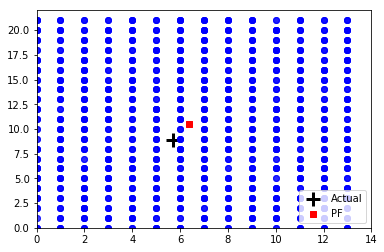

81
[5.2, 8.511111]
MAX location is21.0
max W is : 0.00022932959182949878
min W is : 0.00018502270934739036
final position error, variance:
	 [-11.57356122  -7.69261404] [16.36659162 39.2098838 ]


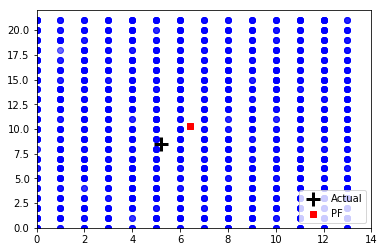

82
[4.7, 8.122222]
MAX location is21.0
max W is : 0.0002667717879763481
min W is : 0.0001622191445807401
final position error, variance:
	 [-11.52259567  -8.34696573] [15.52712545 40.52915988]


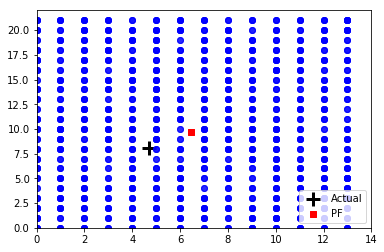

83
[4.2, 7.733333]
MAX location is21.0
max W is : 0.00020694848459160424
min W is : 0.0001940958967941326
final position error, variance:
	 [-11.58242458  -7.46459088] [16.22272039 40.4247292 ]


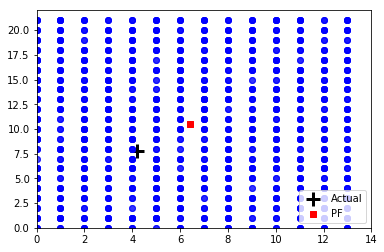

84
[3.7, 7.344444]
MAX location is21.0
max W is : 0.0002600646310972359
min W is : 0.0001718580353094822
final position error, variance:
	 [-11.61607359  -8.32717926] [15.89006883 39.85578057]


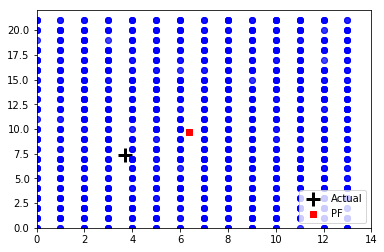

85
[3.2, 6.955556]


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [70]:
from numpy.random import seed
seed(2) 
run_pf1(N=5000, plot_particles=True)

In [60]:
weights

NameError: name 'weights' is not defined

In [ ]:
oraclex2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 100
X = np.linspace(49, 51, N)
Y = np.linspace(49, 51, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([50., 50.])
Sigma = np.array([[ 0.2 , 0.], [0.,  0.2]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)
grid = Z
# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)

# cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
# ax.set_zlim(-0.15,0.2)
# ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(30, 50)

plt.show()

import pylab as pl
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm

# im = plt.matshow(zip(*error_heatmap_averaged), cmap=pl.cm.RdYlGn_r)
im = plt.matshow(grid, cmap=pl.cm.OrRd)

plt.colorbar(im)
plt.show()

In [ ]:
import pylab as pl
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm

# im = plt.matshow(zip(*error_heatmap_averaged), cmap=pl.cm.RdYlGn_r)
im = plt.matshow(grid, cmap=pl.cm.OrRd)

plt.colorbar(im)
plt.show()

In [ ]:
grid

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as sp

x = np.random.randn(100000)
y = np.random.randn(100000)


X = sp.filters.gaussian_filter(x, sigma = 2, order = 0)
Y = sp.filters.gaussian_filter(y, sigma = 2, order = 0)

# normal distribution center at x=0 and y=5
fig1 = plt.subplot(2,2,1)
plt.hist2d(x, y, bins=40)
plt.colorbar()
plt.title('Heatmap without smoothing')
plt.xlabel("X")
plt.ylabel("Y")

In [ ]:
# Add a colorbar if necessary
plt.hexbin(x, y, gridsize=(25,25), cmap=plt.cm.Purples_r)

plt.show()


In [ ]:
np.max(oracle)